In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler
import os
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta 
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
!pip install fastprogress
from fastprogress import master_bar, progress_bar
from itertools import cycle
import datetime as dt

# matplotlib 설정
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

In [2]:
xgb_weights = [3.78227234e-02, 5.35090003e-05, 1.02894781e-04, 1.49786865e-04,
 1.04764847e-04, 1.63700344e-04, 7.86159754e-01, 1.66692644e-01,
 1.62399039e-04, 1.36344403e-04, 1.23864607e-04, 3.25831398e-03,
 1.11413574e-04, 1.12267953e-04, 1.12513058e-04, 1.15435665e-04,
 9.74491413e-05, 7.48724633e-05, 7.42438278e-05, 8.17979526e-05,
 9.10188464e-05, 8.10626516e-05, 1.62408571e-04, 9.22517429e-05,
 6.92411995e-05, 6.06398789e-05, 6.15876997e-05, 2.05707460e-04,
 9.76096126e-05, 9.17855941e-05, 7.44235294e-05, 8.87563365e-05,
 7.44791614e-05, 6.22049338e-05, 6.85490304e-05, 6.57211494e-05,
 6.70680165e-05, 1.42811637e-04, 9.89059918e-05, 9.52478367e-05,
 1.08733664e-04, 8.95528574e-05, 1.07477274e-04, 1.15086681e-04,
 8.60139335e-05, 7.83390569e-05, 6.42610321e-05, 1.03312457e-04,
 9.24527631e-05, 8.45081231e-05, 7.72333588e-05, 8.96328202e-05,
 2.81332632e-05, 2.14036554e-04, 3.18860257e-05, 3.27980561e-05,
 5.04529162e-05, 2.01942370e-04, 7.67721576e-05, 5.93836303e-05,
 6.03012268e-05, 2.65900104e-04, 1.67839185e-04, 8.06350436e-05,
 7.12153196e-05]

tabnet_weights = [4.26892227e-06, 0.00000000e+00, 0.00000000e+00, 3.00723057e-02,
0.00000000e+00, 1.81987064e-06, 1.37099386e-01, 3.07597264e-01,
1.17412334e-05, 0.00000000e+00, 0.00000000e+00, 7.68810592e-02,
6.31930090e-04, 8.53033960e-03, 1.69922775e-02, 8.09343194e-03,
1.85524606e-08, 0.00000000e+00, 5.99931009e-03, 0.00000000e+00,
0.00000000e+00, 0.00000000e+00, 7.60999255e-05, 1.14790590e-06,
1.17366399e-01, 1.14198997e-02, 0.00000000e+00, 3.89959469e-06,
0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.32325158e-05,
0.00000000e+00, 6.57038847e-05, 1.35262607e-02, 2.21752146e-05,
0.00000000e+00, 6.23984265e-02, 8.66896181e-03, 0.00000000e+00,
2.79329075e-03, 1.93734536e-06, 9.73141818e-04, 0.00000000e+00,
2.06456979e-06, 5.23236864e-02, 1.94160263e-02, 4.95664089e-03,
8.15198301e-04, 4.23687933e-02, 4.42582323e-03, 1.96317046e-02,
0.00000000e+00, 2.24109549e-03, 0.00000000e+00, 3.52501762e-03,
4.90427532e-03, 0.00000000e+00, 2.95825462e-03, 0.00000000e+00,
4.75344631e-03, 5.37095814e-03, 0.00000000e+00, 8.05441066e-04,
2.21958440e-02]


In [3]:
train = pd.read_pickle('train.pkl')
test = pd.read_pickle('test.pkl')
val = pd.read_pickle('val.pkl')

# Create a dictionary to map feature names to tabnet_weights
tabnet_weight_dict_train = {col: weight for col, weight in zip(train.columns, tabnet_weights)}
tabnet_weight_dict_test = {col: weight for col, weight in zip(test.columns, tabnet_weights)}
tabnet_weight_dict_val = {col: weight for col, weight in zip(val.columns, tabnet_weights)}

# Apply tabnet_weights to train, test, and val DataFrames
tabnet_train = train * pd.Series(tabnet_weight_dict_train)
tabnet_test = test * pd.Series(tabnet_weight_dict_test)
tabnet_val = val * pd.Series(tabnet_weight_dict_val)

#Now to do same for xgb
# Create a dictionary to map feature names to tabnet_weights
xgb_weight_dict_train = {col: weight for col, weight in zip(train.columns, xgb_weights)}
xgb_weight_dict_test = {col: weight for col, weight in zip(test.columns, xgb_weights)}
xgb_weight_dict_val = {col: weight for col, weight in zip(val.columns, xgb_weights)}

#xgb_weights to train, test, and val DataFrames
xgb_train = train * pd.Series(xgb_weight_dict_train)
xgb_test = test * pd.Series(xgb_weight_dict_test)
xgb_val = val * pd.Series(xgb_weight_dict_val)

In [4]:
import data_preprocess as dpf

xgb_train_norm = dpf.normalize_all(xgb_train)
xgb_test_norm = dpf.normalize_all(xgb_test)
xgb_val_norm = dpf.normalize_all(xgb_val)

tabnet_train_norm = dpf.normalize_all(tabnet_train)
tabnet_test_norm = dpf.normalize_all(tabnet_test)
tabnet_val_norm = dpf.normalize_all(tabnet_val)


In [5]:
train_indices = tabnet_train_norm.index
valid_indices = tabnet_val_norm.index
test_indices = tabnet_test_norm.index


In [6]:
target = 'Power (kW)'
features = [ col for col in tabnet_train_norm.columns if col not in target] 

In [7]:
tabnet_X_train = tabnet_train_norm[features].values[train_indices]
tabnet_y_train = tabnet_train_norm[target].values[train_indices]

tabnet_X_valid = tabnet_val_norm[features].values[valid_indices]
tabnet_y_valid = tabnet_val_norm[target].values[valid_indices]

tabnet_X_test = tabnet_test_norm[features].values[test_indices]
tabnet_y_test = tabnet_test_norm[target].values[test_indices]


In [8]:
def torch_tensor_creator(df):
    # Convert DataFrame to a numpy array
    data_array = df.values

    # Convert numpy array to a PyTorch tensor
    tensor_data = torch.tensor(data_array, dtype=torch.float)


    # Assuming 'data' is your PyTorch tensor
    has_nans = torch.isnan(tensor_data).any().item()

    if has_nans:
        # Assuming 'tensor_data' is your PyTorch tensor containing the data
    # Find the indices of columns with NaN values
        nan_columns_indices = torch.any(torch.isnan(tensor_data), dim=0).nonzero().squeeze()

        # Remove the columns with NaN values
        tensor_data_without_nan = torch.cat(
            [tensor_data[:, i].unsqueeze(1) for i in range(tensor_data.size(1)) if i not in nan_columns_indices],
            dim=1
        )
    else:
        tensor_data_without_nan = tensor_data
    # Assuming 'data' is your PyTorch tensor
    has_nans = torch.isnan(tensor_data_without_nan)

    # Count the number of NaN values in each column
    num_nans_per_column = torch.sum(has_nans, dim=0)

    return tensor_data_without_nan


In [9]:
xgb_X_train = torch_tensor_creator(xgb_train_norm[features])
xgb_y_train = torch_tensor_creator(xgb_train_norm[target])
xgb_X_valid = torch_tensor_creator(xgb_val_norm[features])
xgb_y_valid = torch_tensor_creator(xgb_val_norm[target])
xgb_X_test = torch_tensor_creator(xgb_test_norm[features])
xgb_y_test = torch_tensor_creator(xgb_test_norm[target])


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random

# Define the custom sampler for the data loader
class CustomBatchSampler(torch.utils.data.Sampler):
    def __init__(self, data_source, batch_size=432, overlap=10):
        self.data_source = data_source
        self.batch_size = batch_size
        self.overlap = overlap

    def __iter__(self):
        indices = list(range(len(self.data_source)))
        for start_idx in range(0, len(indices) - self.batch_size + 1, self.batch_size - self.overlap):
            yield indices[start_idx : start_idx + self.batch_size]

    def __len__(self):
        return (len(self.data_source) - self.batch_size) // (self.batch_size - self.overlap) + 1

# Create the custom batch sampler
batch_size = 526
overlap = 60
train_custom_sampler = CustomBatchSampler(range(len(xgb_X_train)), batch_size, overlap)
valid_custom_sampler = CustomBatchSampler(range(len(xgb_X_valid)), batch_size, overlap)

# Create the data loaders using the custom sampler
train_dataset = TensorDataset(xgb_X_train, xgb_y_train)
train_loader = DataLoader(train_dataset, batch_sampler=train_custom_sampler)

valid_dataset = TensorDataset(xgb_X_valid, xgb_y_valid)
valid_loader = DataLoader(valid_dataset, batch_sampler=valid_custom_sampler)

# Define the stacked LSTM with self-attention
class StackedLSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, attention_size, output_size):
        super(StackedLSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention_size = attention_size

        # Stacked LSTM layers
        self.lstm_stack = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

        # Attention layer
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, attention_size),
            nn.Tanh(),
            nn.Linear(attention_size, 1),
            nn.Softmax(dim=1)
        )

        # Output layer
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, _ = self.lstm_stack(x, (h0.detach(), c0.detach()))

        # Attention mechanism
        attention_weights = self.attention(out)
        attention_out = torch.sum(attention_weights * out, dim=1)

        # Output layer
        output = self.fc(attention_out)

        return output



In [11]:

import torch
import torch.nn as nn
import torch_optimizer as toptim

class RMSECriterion(nn.Module):
    def __init__(self):
        super(RMSECriterion, self).__init__()

    def forward(self, outputs, targets):
        return torch.sqrt(torch.mean((outputs - targets) ** 2))
    

In [22]:
# Hyperparameters
input_size = 64
output_size = 1

# Hyperparameter search space
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [256, 512, 1024]
num_layers_values = [1, 2, 3]
hidden_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.1, 0.2]
attention_sizes = [32, 64, 128]

best_loss = float('inf')
best_hyperparameters = None

# Perform random search
num_search_iterations = 10
for search_iteration in range(num_search_iterations):
    # Randomly sample hyperparameters from the search space
    lr = random.choice(learning_rates)
    batch_size = random.choice(batch_sizes)
    num_layers = random.choice(num_layers_values)
    hidden_size = random.choice(hidden_sizes)
    dropout_rate = random.choice(dropout_rates)
    attention_size = random.choice(attention_sizes)

    # Initialize the model with sampled hyperparameters
    model = StackedLSTMWithAttention(input_size, hidden_size, num_layers, attention_size, output_size)

    optimizer = toptim.RAdam(model.parameters(), lr=0.0001)
    optimizer = toptim.Lookahead(optimizer=optimizer, k=5, alpha=0.5)   
    criterion = RMSECriterion()

    # Training loop
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Reshape data to (batch_size, sequence_length, input_size)
            data = data.view(-1, 526, 64)

            # Forward pass
            outputs = model(data)

            # Flatten the predictions and targets for loss calculation
            outputs = outputs.view(-1)
            target = target.view(-1)

            # Compute the loss
            loss = criterion(outputs, target)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print batch loss
            if batch_idx % 10 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item()}")

    # Validation loop
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for data, target in valid_loader:
            # Reshape data to (batch_size, sequence_length, input_size)
            data = data.view(-1, 526, 64)

            outputs = model(data)
            outputs = outputs.view(-1)
            target = target.view(-1)

            loss = criterion(outputs, target)
            total_loss += loss.item()

        average_loss = total_loss / len(valid_loader)

        # Check if this combination of hyperparameters is the best so far
        if average_loss < best_loss:
            best_loss = average_loss
            best_hyperparameters = {
                'lr': lr,
                'batch_size': batch_size,
                'num_layers': num_layers,
                'hidden_size': hidden_size,
                'dropout_rate': dropout_rate
            }

        print(f"Search Iteration [{search_iteration+1}/{num_search_iterations}], "
              f"Validation Loss: {average_loss}")

# Print the best hyperparameters found during the search
print("Best Hyperparameters:")
print(best_hyperparameters)


Epoch [0/50], Batch [0/168], Loss: 0.4028943181037903
Epoch [0/50], Batch [10/168], Loss: 0.39460232853889465
Epoch [0/50], Batch [20/168], Loss: 0.5339257121086121
Epoch [0/50], Batch [30/168], Loss: 0.39726728200912476
Epoch [0/50], Batch [40/168], Loss: 0.3225715458393097
Epoch [0/50], Batch [50/168], Loss: 0.17228981852531433
Epoch [0/50], Batch [60/168], Loss: 0.7346897721290588
Epoch [0/50], Batch [70/168], Loss: 0.9320637583732605
Epoch [0/50], Batch [80/168], Loss: 0.5219056606292725
Epoch [0/50], Batch [90/168], Loss: 0.34175652265548706
Epoch [0/50], Batch [100/168], Loss: 0.3120022118091583
Epoch [0/50], Batch [110/168], Loss: 0.7091003060340881
Epoch [0/50], Batch [120/168], Loss: 0.236334890127182
Epoch [0/50], Batch [130/168], Loss: 0.294872522354126
Epoch [0/50], Batch [140/168], Loss: 0.46139171719551086
Epoch [0/50], Batch [150/168], Loss: 0.13283514976501465
Epoch [0/50], Batch [160/168], Loss: 0.15298275649547577
Epoch [1/50], Batch [0/168], Loss: 0.25551778078079224

In [ ]:
#best_hyperparameters = {'lr': 0.0001, 'batch_size': 512, 'num_layers': 3, 'hidden_size': 64, 'dropout_rate': 0.01}

In [ ]:
# Hyperparameters
#input_size = 64
#output_size = 1

Epoch [0/50], Batch [0/168], Loss: 0.11305885016918182
Epoch [0/50], Batch [10/168], Loss: 0.056144069880247116
Epoch [0/50], Batch [20/168], Loss: 0.14542001485824585
Epoch [0/50], Batch [30/168], Loss: 0.051546938717365265
Epoch [0/50], Batch [40/168], Loss: 0.04324370622634888
Epoch [0/50], Batch [50/168], Loss: 0.033833522349596024
Epoch [0/50], Batch [60/168], Loss: 0.16049477458000183
Epoch [0/50], Batch [70/168], Loss: 0.23976682126522064
Epoch [0/50], Batch [80/168], Loss: 0.07077832520008087
Epoch [0/50], Batch [90/168], Loss: 0.0745563954114914
Epoch [0/50], Batch [100/168], Loss: 0.08194588124752045
Epoch [0/50], Batch [110/168], Loss: 0.1468757539987564
Epoch [0/50], Batch [120/168], Loss: 0.03760146722197533
Epoch [0/50], Batch [130/168], Loss: 0.06266375631093979
Epoch [0/50], Batch [140/168], Loss: 0.0950651615858078
Epoch [0/50], Batch [150/168], Loss: 0.03820684552192688
Epoch [0/50], Batch [160/168], Loss: 0.023612169548869133
Epoch [0/50], Validation Loss: 0.07522184

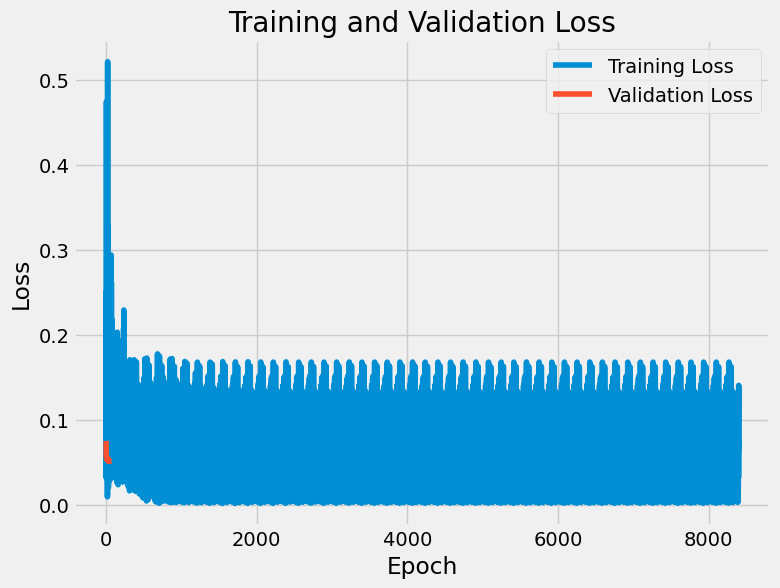

Overall RMSE on Validation Set: 0.21236495484005322


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
from torch_optimizer import Lookahead
import matplotlib.pyplot as plt

# ... (rest of your previous code)

# Retrain the model using the best hyperparameters found during the search
best_model = StackedLSTMWithAttention(input_size, best_hyperparameters['hidden_size'],
                                      best_hyperparameters['num_layers'],
                                      attention_size, output_size)
optimizer = optim.Adam(best_model.parameters(), lr=0.0001)
optimizer = Lookahead(optimizer=optimizer, k=5, alpha=0.5)
criterion = nn.MSELoss()

train_losses = []  # Store training losses for plotting
valid_losses = []  # Store validation losses for plotting

num_epochs = 50
for epoch in range(num_epochs):
    best_model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Reshape data to (batch_size, sequence_length, input_size)
        data = data.view(-1, 526, 64)

        # Forward pass
        outputs = best_model(data)

        # Flatten the predictions and targets for loss calculation
        outputs = outputs.view(-1)
        target = target.view(-1)

        # Compute the loss
        loss = criterion(outputs, target)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the training loss
        train_losses.append(loss.item())

        # Print batch loss
        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item()}")

    # Validation loop
    best_model.eval()
    with torch.no_grad():
        total_loss = 0
        for data, target in valid_loader:
            # Reshape data to (batch_size, sequence_length, input_size)
            data = data.view(-1, 526, 64)

            outputs = best_model(data)
            outputs = outputs.view(-1)
            target = target.view(-1)

            loss = criterion(outputs, target)
            total_loss += loss.item()

        average_loss = total_loss / len(valid_loader)
        valid_losses.append(average_loss)

        print(f"Epoch [{epoch}/{num_epochs}], Validation Loss: {average_loss}")

# Plot the training and validation losses over epochs
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Calculate RMSE error for validation set
best_model.eval()
with torch.no_grad():
    total_rmse = 0.0
    num_samples = 0
    for data, target in valid_loader:
        # Reshape data to (batch_size, sequence_length, input_size)
        data = data.view(-1, 526, 64)

        outputs = best_model(data)
        outputs = outputs.view(-1)
        target = target.view(-1)

        # Calculate RMSE for this batch
        rmse = torch.sqrt(criterion(outputs, target))
        total_rmse += rmse.item() * len(target)
        num_samples += len(target)

        # Visualize the predicted values against true target values for the first batch
        if num_samples <= len(valid_loader.batch_sampler):
            plt.figure(figsize=(8, 6))
            plt.plot(target.cpu().numpy(), label='True Values')
            plt.plot(outputs.cpu().numpy(), label='Predicted Values')
            plt.xlabel('Sample Index')
            plt.ylabel('Value')
            plt.title('True vs. Predicted Values (Validation Batch)')
            plt.legend()
            plt.show()

    # Calculate overall RMSE for the entire validation set
    overall_rmse = total_rmse / num_samples
    print(f"Overall RMSE on Validation Set: {overall_rmse}")


In [30]:
# Calculate RMSE error for validation set and visualize predictions
best_model.eval()
with torch.no_grad():
    total_rmse = 0.0
    num_samples = 0
    for data, target in valid_loader:
        # Reshape data to (batch_size, sequence_length, input_size)
        data = data.view(-1, 526, 64)

        outputs = best_model(data)
        outputs = outputs.view(-1)
        target = target.view(-1)

        # Calculate RMSE for this batch
        rmse = torch.sqrt(criterion(outputs, target))
        total_rmse += rmse.item() * len(target)
        num_samples += len(target)

        # Visualize the predicted values against true target values for the first batch
        if num_samples <= len(valid_loader.batch_sampler):
            subset_indices = torch.linspace(0, len(target) - 1, steps=1000).long()
            subset_target = target[subset_indices].cpu().numpy()
            subset_outputs = outputs[subset_indices].cpu().numpy()

            plt.figure(figsize=(10, 6))
            plt.plot(subset_target, label='True Values')
            plt.plot(subset_outputs, label='Predicted Values')
            plt.xlabel('Sample Index')
            plt.ylabel('Value')
            plt.title('True vs. Predicted Values (Validation Batch)')
            plt.legend()

            # Save the plot as an image file
            plt.savefig(f'prediction_plot_batch{num_samples}.png')
            plt.close()  # Close the current plot to avoid overlapping in subsequent iterations

    # Calculate overall RMSE for the entire validation set
    overall_rmse = total_rmse / num_samples
    print(f"Overall RMSE on Validation Set: {overall_rmse}")


Overall RMSE on Validation Set: 0.21236495484005322


In [37]:
import os
!pip install matplotlib
import matplotlib as plt

# Set the output directory for saving the plots
output_dir = 'validation_plots'
os.makedirs(output_dir, exist_ok=True)

# Calculate RMSE error for validation set and visualize predictions
best_model.eval()
with torch.no_grad():
    total_rmse = 0.0
    num_samples = 0
    for data, target in valid_loader:
        # Reshape data to (batch_size, sequence_length, input_size)
        data = data.view(-1, 526, 64)

        outputs = best_model(data)
        outputs = outputs.view(-1)
        target = target.view(-1)

        # Calculate RMSE for this batch
        rmse = torch.sqrt(criterion(outputs, target))
        total_rmse += rmse.item() * len(target)
        num_samples += len(target)

        # Visualize the predicted values against true target values for the first batch
        if num_samples <= len(valid_loader.batch_sampler):
            subset_indices = torch.linspace(0, len(target) - 1, steps=1000).long()
            subset_target = target[subset_indices].cpu().numpy()
            subset_outputs = outputs[subset_indices].cpu().numpy()

            plt.figure(figsize=(10, 6))
            plt.plot(subset_target, label='True Values')
            plt.plot(subset_outputs, label='Predicted Values')
            plt.xlabel('Sample Index')
            plt.ylabel('Value')
            plt.title(f'True vs. Predicted Values (Validation Batch {num_samples})')
            plt.legend()

            # Save the plot as an image file in the output directory
            plt.savefig(os.path.join(output_dir, f'prediction_plot_batch{num_samples}.png'))
            plt.close()  # Close the current plot to avoid overlapping in subsequent iterations

    # Calculate overall RMSE for the entire validation set
    overall_rmse = total_rmse / num_samples
    print(f"Overall RMSE on Validation Set: {overall_rmse}")


Overall RMSE on Validation Set: 0.21236495484005322


In [41]:
# Calculate RMSE error for validation set and visualize predictions
best_model.eval()
with torch.no_grad():
    total_rmse = 0.0
    num_samples = 0
    for data, target in valid_loader:
        # Reshape data to (batch_size, sequence_length, input_size)
        data = data.view(-1, 526, 64)
        #print(target)
        outputs = best_model(data)
        #print(outputs)
        outputs = outputs.view(-1)
        target = target.view(-1)
        # Calculate RMSE for this batch
        rmse = torch.sqrt(criterion(outputs, target))
        total_rmse += rmse.item() * len(target)
        num_samples += len(target)
        print(num_samples)

        # Visualize the predicted values against true target values for the first batch
        if num_samples <= len(valid_loader.batch_sampler):
            subset_indices = torch.linspace(0, len(target) - 1, steps=1000).long()
            subset_target = target[subset_indices].cpu().numpy()
            subset_outputs = outputs[subset_indices].cpu().numpy()

            plt.figure(figsize=(10, 6))
            plt.plot(subset_target, label='True Values')
            plt.plot(subset_outputs, label='Predicted Values')
            plt.xlabel('Sample Index')
            plt.ylabel('Value')
            plt.title(f'True vs. Predicted Values (Validation Batch {num_samples})')
            plt.show()  # Close the current plot to avoid overlapping in subsequent iterations

    # Calculate overall RMSE for the entire validation set
    overall_rmse = total_rmse / num_samples
    print(f"Overall RMSE on Validation Set: {overall_rmse}")


526
1052
1578
2104
2630
3156
3682
4208
4734
5260
5786
6312
6838
7364
7890
8416
8942
9468
9994
10520
11046
11572
12098
12624
13150
13676
14202
14728
15254
15780
16306
16832
17358
17884
18410
18936
19462
19988
20514
21040
21566
22092
22618
23144
23670
24196
24722
25248
25774
26300
26826
27352
27878
28404
28930
Overall RMSE on Validation Set: 0.21236495484005322


28930


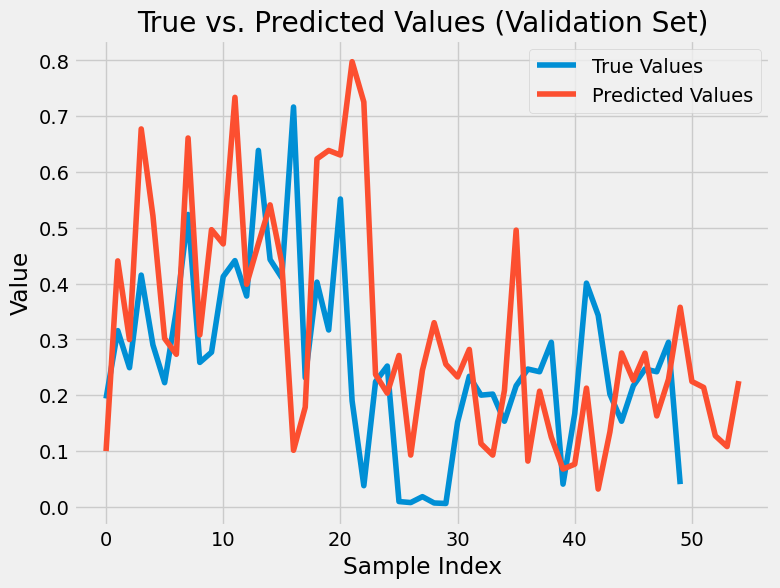

Overall RMSE on Validation Set: 0.21236495484005322


In [138]:
import matplotlib.pyplot as plt
import random
# Calculate RMSE error for validation set
best_model.eval()
with torch.no_grad():
    total_rmse = 0.0
    num_samples = 0
    true_values_list = []
    predicted_values_list = []

    for data, target in valid_loader:
        # Reshape data to (batch_size, sequence_length, input_size)
        data = data.view(-1, 526, 64)

        outputs = best_model(data)
        outputs = outputs.view(-1)
        target = target.view(-1)

        # Calculate RMSE for this batch
        rmse = torch.sqrt(criterion(outputs, target))
        total_rmse += rmse.item() * len(target)
        num_samples += len(target)

        # Store the true and predicted values for each batch
        true_values_list.append(target.cpu().numpy())
        predicted_values_list.append(outputs.cpu().numpy())
        

# Concatenate true and predicted values for all batches
true_values = np.concatenate(true_values_list)
predicted_values = np.concatenate(predicted_values_list)

print(len(true_values))
# Convert true_values to a list if it's not already in list format
if not isinstance(true_values, list):
    true_values = list(true_values)



# Ensure that data_list has at least 50 elements
if len(true_values) < 300:
    raise ValueError("The dataset should have at least 300 elements.")

# Generate a random starting index within the valid range
random_start_index = random.randint(0, len(true_values) - 300)

# Extract 50 consecutive elements starting from the random_start_index
random_50_consecutive_numbers = true_values[random_start_index : random_start_index + 300]

# Now you can use random_50_consecutive_numbers for visualization or any other purpose
every_sixth_element = random_50_consecutive_numbers[::6]
# Visualize the predicted values against true target values for the entire validation set
plt.figure(figsize=(8, 6))
plt.plot(every_sixth_element, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs. Predicted Values (Validation Set)')
plt.legend()
plt.show()

# Calculate overall RMSE for the entire validation set
overall_rmse = total_rmse / num_samples
print(f"Overall RMSE on Validation Set: {overall_rmse}")
